In [1]:
# Import important libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
import scipy.stats
from sklearn.preprocessing import PowerTransformer

pd.set_option('max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#from pycaret.regression import setup, compare_models


### Creating Master Data

In [2]:
# create master_data
cab= pd.read_csv('Cab_Data.csv')
transaction_id= pd.read_csv('Transaction_ID.csv')
customer_id= pd.read_csv('Customer_ID.csv')
city = pd.read_csv('City.csv')

# creating master dataset
master_data= cab.merge(transaction_id, on= 'Transaction ID').merge(customer_id, on='Customer ID').merge(city, on='City')

# look at the first few rows of the master dataframe
master_data.head(3)

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Population,Users
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,29290,Card,Male,28,10813,"814,885","24,701"
1,10351127,43302,Yellow Cab,ATLANTA GA,26.19,598.70,317.4228,29290,Cash,Male,28,10813,"814,885","24,701"
2,10412921,43427,Yellow Cab,ATLANTA GA,42.55,792.05,597.4020,29290,Card,Male,28,10813,"814,885","24,701"


In [3]:
# get some info about the data
master_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359392 entries, 0 to 359391
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Transaction ID      359392 non-null  int64  
 1   Date of Travel      359392 non-null  int64  
 2   Company             359392 non-null  object 
 3   City                359392 non-null  object 
 4   KM Travelled        359392 non-null  float64
 5   Price Charged       359392 non-null  float64
 6   Cost of Trip        359392 non-null  float64
 7   Customer ID         359392 non-null  int64  
 8   Payment_Mode        359392 non-null  object 
 9   Gender              359392 non-null  object 
 10  Age                 359392 non-null  int64  
 11  Income (USD/Month)  359392 non-null  int64  
 12  Population          359392 non-null  object 
 13  Users               359392 non-null  object 
dtypes: float64(3), int64(5), object(6)
memory usage: 41.1+ MB


In [4]:
# descriptive statistics for numeric features 

master_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Transaction ID,359392.0,1.022076e+07,126805.803715,10000011.0,1.011081e+07,10221035.50,1.033094e+07,10440107.00
Date of Travel,359392.0,4.296407e+04,307.467197,42371.0,4.269700e+04,42988.00,4.323200e+04,43465.00
KM Travelled,359392.0,2.256725e+01,12.233526,1.9,1.200000e+01,22.44,3.296000e+01,48.00
Price Charged,359392.0,4.234433e+02,274.378911,15.6,2.064375e+02,386.36,5.836600e+02,2048.03
Cost of Trip,359392.0,2.861901e+02,157.993661,19.0,1.512000e+02,282.48,4.136832e+02,691.20
Customer ID,359392.0,1.919165e+04,21012.412463,1.0,2.705000e+03,7459.00,3.607800e+04,60000.00
Age,359392.0,3.533670e+01,12.594234,18.0,2.500000e+01,33.00,4.200000e+01,65.00
Income (USD/Month),359392.0,1.504882e+04,7969.409482,2000.0,8.424000e+03,14685.00,2.103500e+04,35000.00


In [5]:
# drop unnecessary columns
master_data.drop(['Transaction ID', 'Customer ID'], axis= 1, inplace= True)

### Data Cleaning

In [6]:
# removing  space from column name 

master_data.columns= master_data.columns.str.replace(' ','_')

# removing ',' from Population and Users column values

for column in master_data[['Population', 'Users']]:
    master_data[column]= master_data[column].str.replace(',','').astype('int')
    

In [7]:
master_data.head(3)

,Date_of_Travel,Company,City,KM_Travelled,Price_Charged,Cost_of_Trip,Payment_Mode,Gender,Age,Income_(USD/Month),Population,Users
0,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,Card,Male,28,10813,814885,24701
1,43302,Yellow Cab,ATLANTA GA,26.19,598.70,317.4228,Cash,Male,28,10813,814885,24701
2,43427,Yellow Cab,ATLANTA GA,42.55,792.05,597.4020,Card,Male,28,10813,814885,24701


In [8]:
# Handle null/missing values

master_data.isnull().sum()

Date_of_Travel        0
Company               0
City                  0
KM_Travelled          0
Price_Charged         0
Cost_of_Trip          0
Payment_Mode          0
Gender                0
Age                   0
Income_(USD/Month)    0
Population            0
Users                 0
dtype: int64

In [9]:
# handling duplicates

master_data.duplicated().sum()

0

In [10]:
# Parsing dates

def to_date_format(n):
    date_str =(datetime(1899,12,30) + timedelta(n-1)).strftime("%d-%m-%Y")
    date_date =  datetime.strptime(date_str, "%d-%m-%Y")
    return date_date

master_data['Date_of_Travel']=master_data['Date_of_Travel'].apply(lambda x:to_date_format(x)) 

In [11]:
master_data.head()

,Date_of_Travel,Company,City,KM_Travelled,Price_Charged,Cost_of_Trip,Payment_Mode,Gender,Age,Income_(USD/Month),Population,Users
0,2016-01-07,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,Card,Male,28,10813,814885,24701
1,2018-07-20,Yellow Cab,ATLANTA GA,26.19,598.70,317.4228,Cash,Male,28,10813,814885,24701
2,2018-11-22,Yellow Cab,ATLANTA GA,42.55,792.05,597.4020,Card,Male,28,10813,814885,24701
3,2016-01-05,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,Card,Male,27,9237,814885,24701
4,2018-04-20,Yellow Cab,ATLANTA GA,36.38,721.10,467.1192,Card,Male,27,9237,814885,24701


### Features Engineering

In [12]:
# Extracting the year, month and day features
master_data['Year'] = master_data['Date_of_Travel'].dt.year
master_data['Month']= master_data['Date_of_Travel'].dt.month
master_data['Day']= master_data['Date_of_Travel'].dt.day

In [13]:
# drop date of travel
master_data.drop('Date_of_Travel', axis= 1, inplace= True)

### Features Transformation

In [14]:
# select numeric features
numeric_columns= master_data.select_dtypes(np.number).columns
numeric_columns

Index(['KM_Travelled', 'Price_Charged', 'Cost_of_Trip', 'Age',
       'Income_(USD/Month)', 'Population', 'Users', 'Year', 'Month', 'Day'],
      dtype='object')

In [15]:
# measuring skewness for numeric features

skew_value= []

for column in numeric_columns:
    skew_value.append(master_data[column].skew())
    
pd.DataFrame(index= numeric_columns, data= skew_value, columns= ['skew_value'])

,skew_value
KM_Travelled,0.055779
Price_Charged,0.873761
Cost_of_Trip,0.137958
Age,0.685339
Income_(USD/Month),0.309562
Population,0.905621
Users,0.269568
Year,-0.075208
Month,-0.401624
Day,0.022325


- all of the features are positively skewed(skewness > 0) because more weights are on the left side of the distribution.

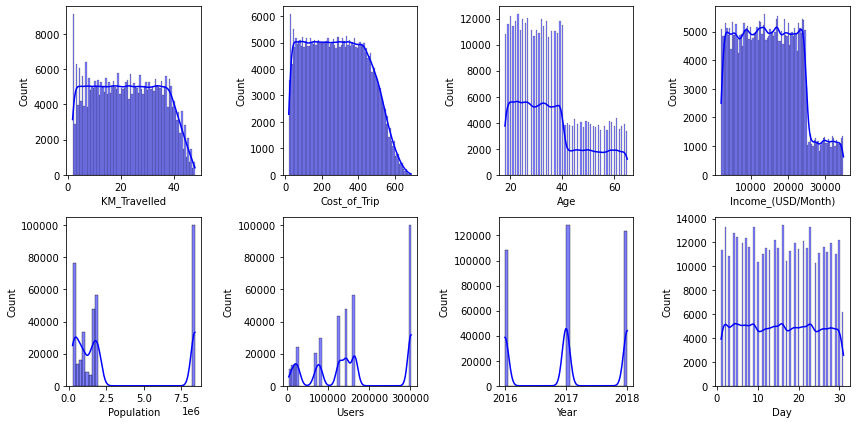

In [16]:
fig, axes= plt.subplots(2,4, figsize= (12,6))

sns.histplot(master_data['KM_Travelled'], color= 'blue' , ax= axes[0,0], palette='bright', kde= True )
sns.histplot(master_data['Cost_of_Trip'], color= 'blue' , ax= axes[0,1], palette='bright', kde= True )
sns.histplot(master_data['Age'], color= 'blue' , ax= axes[0,2], palette='bright', kde= True )
sns.histplot(master_data['Income_(USD/Month)'], color= 'blue' , ax= axes[0,3], palette='bright', kde= True )
sns.histplot(master_data['Population'], color= 'blue' , ax= axes[1,0], palette='bright', kde= True )
sns.histplot(master_data['Users'], color= 'blue' , ax= axes[1,1], palette='bright', kde= True )
sns.histplot(master_data['Year'], color= 'blue' , ax= axes[1,2], palette='bright', kde= True )
sns.histplot(master_data['Day'], color= 'blue' , ax= axes[1,3], palette='bright', kde= True )

plt.tight_layout()

In [17]:
# transforming positively skewed features
numeric_columns= ['KM_Travelled', 'Cost_of_Trip', 'Age','Income_(USD/Month)', 
                  'Population', 'Users', 'Year',  'Day']

for column in numeric_columns:
    
    master_data[column]= np.log1p(master_data[column])
    

In [18]:
master_data.select_dtypes(np.number).head()

,KM_Travelled,Price_Charged,Cost_of_Trip,Age,Income_(USD/Month),Population,Users,Year,Month,Day
0,3.448399,370.95,5.751413,3.367296,9.288597,13.610804,10.114639,7.609367,1,2.079442
1,3.302849,598.70,5.763380,3.367296,9.288597,13.610804,10.114639,7.610358,7,3.044522
2,3.773910,792.05,6.394263,3.367296,9.288597,13.610804,10.114639,7.610358,11,3.135494
3,3.388450,358.52,5.816677,3.332205,9.131081,13.610804,10.114639,7.609367,1,1.791759
4,3.621136,721.10,6.148723,3.332205,9.131081,13.610804,10.114639,7.610358,4,3.044522


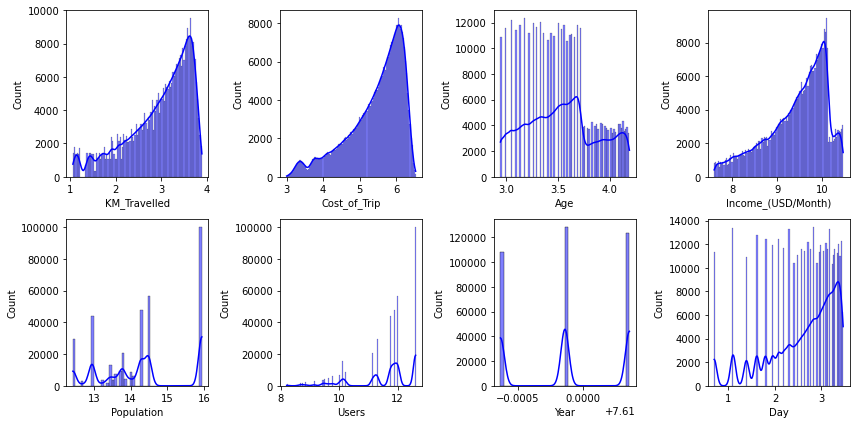

In [19]:
# check distribution of transformed features
fig, axes= plt.subplots(2,4, figsize= (12,6))

sns.histplot(master_data['KM_Travelled'], color= 'blue' , ax= axes[0,0], palette='bright', kde= True )
sns.histplot(master_data['Cost_of_Trip'], color= 'blue' , ax= axes[0,1], palette='bright', kde= True )
sns.histplot(master_data['Age'], color= 'blue' , ax= axes[0,2], palette='bright', kde= True )
sns.histplot(master_data['Income_(USD/Month)'], color= 'blue' , ax= axes[0,3], palette='bright', kde= True )
sns.histplot(master_data['Population'], color= 'blue' , ax= axes[1,0], palette='bright', kde= True )
sns.histplot(master_data['Users'], color= 'blue' , ax= axes[1,1], palette='bright', kde= True )
sns.histplot(master_data['Year'], color= 'blue' , ax= axes[1,2], palette='bright', kde= True )
sns.histplot(master_data['Day'], color= 'blue' , ax= axes[1,3], palette='bright', kde= True )

plt.tight_layout()

In [20]:
# transforming month column
master_data['Month']= -np.cos(0.5236* master_data['Month'])

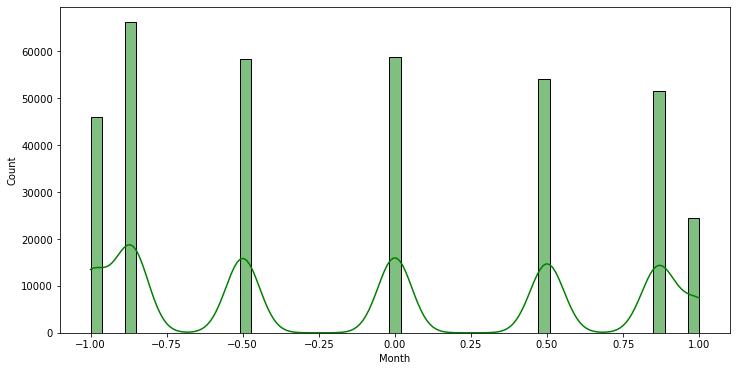

In [21]:
# distribution of month after transformation
plt.figure(figsize=(12,6))
sns.histplot(data= master_data, x= 'Month', color= 'Green', kde= True, palette= 'bright');

In [22]:
# descriptive statistics of the target variable i.e. 'Price_ charged'

master_data['Price_Charged'].describe().T

count    359392.000000
mean        423.443311
std         274.378911
min          15.600000
25%         206.437500
50%         386.360000
75%         583.660000
max        2048.030000
Name: Price_Charged, dtype: float64

In [23]:
# transform the target variable 

master_data['Price_Charged']= np.log1p(master_data['Price_Charged'])


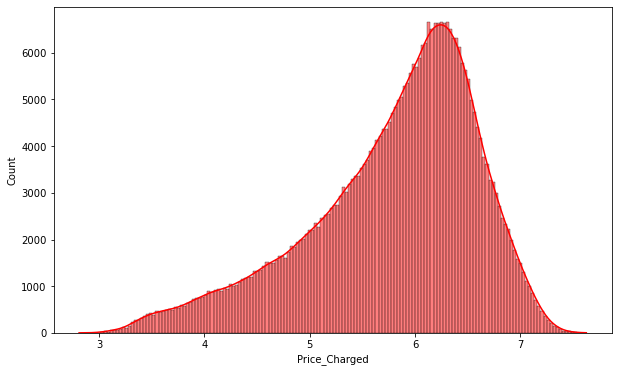

In [24]:
# distribution of target variable after transformation

plt.figure(figsize=(10,6))
sns.histplot(data= master_data, x= 'Price_Charged', color= 'red', kde= True, palette= 'bright');

### Feature Selection

In [25]:
# feature selection with correlation

master_data.corr() ['Price_Charged'] 

KM_Travelled          0.929757
Price_Charged         1.000000
Cost_of_Trip          0.942869
Age                  -0.002404
Income_(USD/Month)    0.002390
Population            0.208115
Users                 0.138402
Year                 -0.026551
Month                -0.001855
Day                  -0.004073
Name: Price_Charged, dtype: float64

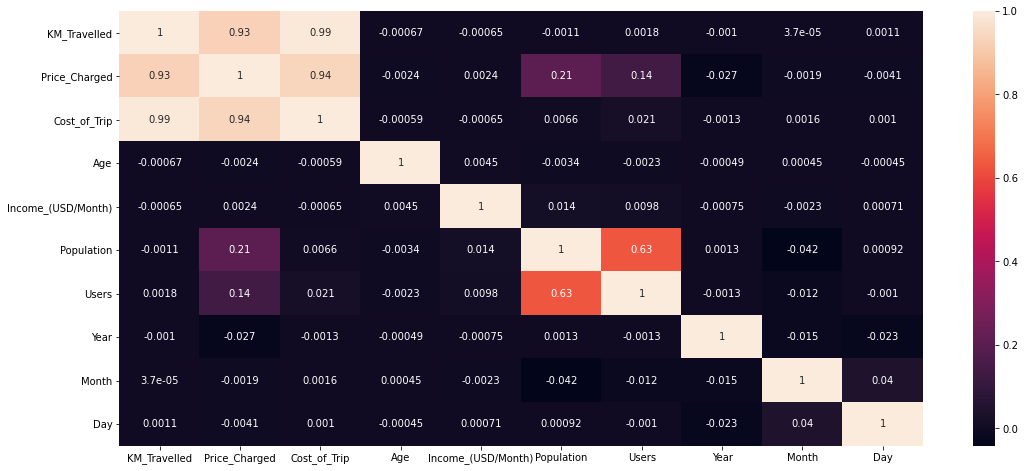

In [26]:
plt.figure(figsize= (18,8))
sns.heatmap(master_data.corr(), annot= True);

#### Correlation between Variables

- There is high correlation between some of the features. These are:
    
    - 'KM_Travelled' and 'Price_Charged'
    - 'KM_Travelled' and 'Cost_of_Trip'
    - 'Price_charged' and 'Cost_of_Trip'
    
- therefore, I decided to drop 'KM_Travelled'

In [27]:
# droping 'KM_Travelled'

master_data['KM_Travelled']= master_data.drop('KM_Travelled', axis=1, inplace= True)

### One-Hot Encoding

In [28]:
# Encoding catagorical features
master_data= pd.get_dummies(master_data, drop_first= True)
master_data.head()

,Price_Charged,Cost_of_Trip,Age,Income_(USD/Month),Population,Users,Year,Month,Day,Company_Yellow Cab,City_AUSTIN TX,City_BOSTON MA,City_CHICAGO IL,City_DALLAS TX,City_DENVER CO,City_LOS ANGELES CA,City_MIAMI FL,City_NASHVILLE TN,City_NEW YORK NY,City_ORANGE COUNTY,City_PHOENIX AZ,City_PITTSBURGH PA,City_SACRAMENTO CA,City_SAN DIEGO CA,City_SEATTLE WA,City_SILICON VALLEY,City_TUCSON AZ,City_WASHINGTON DC,Payment_Mode_Cash,Gender_Male
0,5.918759,5.751413,3.367296,9.288597,13.610804,10.114639,7.609367,-0.866025,2.079442,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,6.396430,5.763380,3.367296,9.288597,13.610804,10.114639,7.610358,0.866021,3.044522,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,6.675886,6.394263,3.367296,9.288597,13.610804,10.114639,7.610358,-0.866032,3.135494,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,5.884770,5.816677,3.332205,9.131081,13.610804,10.114639,7.609367,-0.866025,1.791759,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,6.582164,6.148723,3.332205,9.131081,13.610804,10.114639,7.610358,0.500004,3.044522,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [29]:
master_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359392 entries, 0 to 359391
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Price_Charged        359392 non-null  float64
 1   Cost_of_Trip         359392 non-null  float64
 2   Age                  359392 non-null  float64
 3   Income_(USD/Month)   359392 non-null  float64
 4   Population           359392 non-null  float64
 5   Users                359392 non-null  float64
 6   Year                 359392 non-null  float64
 7   Month                359392 non-null  float64
 8   Day                  359392 non-null  float64
 9   Company_Yellow Cab   359392 non-null  uint8  
 10  City_AUSTIN TX       359392 non-null  uint8  
 11  City_BOSTON MA       359392 non-null  uint8  
 12  City_CHICAGO IL      359392 non-null  uint8  
 13  City_DALLAS TX       359392 non-null  uint8  
 14  City_DENVER CO       359392 non-null  uint8  
 15  City_LOS ANGELES 

### Split the Dataset

In [30]:
# split the data set into predictor and target variable

X= master_data.drop('Price_Charged', axis= 1)
y= master_data['Price_Charged']

In [31]:
# train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 42)


In [32]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape  

((251574, 29), (251574,), (107818, 29), (107818,))

### Features Scaling

In [33]:
scaler= StandardScaler()

scaled_X_train= scaler.fit_transform(X_train)

scaled_X_test = scaler.transform(X_test)

In [34]:
scaler.mean_[:20]

array([ 5.43958782e+00,  3.53485363e+00,  9.43851386e+00,  1.43220987e+01,
        1.16335223e+01,  7.60988283e+00, -1.00400265e-01,  2.60722803e+00,
        7.64276118e-01,  1.38448329e-02,  8.21905284e-02,  1.57591802e-01,
        1.95886697e-02,  1.06847289e-02,  1.34079833e-01,  1.79907304e-02,
        8.24807015e-03,  2.77814878e-01,  1.12571251e-02,  5.90283575e-03])

In [35]:
scaler.var_[:20]

array([5.66616622e-01, 1.15056217e-01, 4.36176846e-01, 1.37782215e+00,
       9.88568839e-01, 1.57572757e-07, 5.09838091e-01, 5.18938417e-01,
       1.80158134e-01, 1.36531535e-02, 7.54352455e-02, 1.32756626e-01,
       1.92049538e-02, 1.05705655e-02, 1.16102432e-01, 1.76670640e-02,
       8.18003949e-03, 2.00633771e-01, 1.11304023e-02, 5.86799228e-03])

### Model Selection

#### Linear Regression

In [36]:
# Linear regression
linear_model= LinearRegression()

linear_model.fit(scaled_X_train, y_train)

LinearRegression()

In [37]:
y_pred= linear_model.predict(scaled_X_test)

In [38]:
# evaluate model performance
mae= mean_absolute_error(y_test,y_pred)
mae

0.13846024556698114

In [39]:
# evaluate model performance
mse= mean_squared_error(y_test, y_pred)
mse

0.030544861511077694

In [40]:
# measure goodness of fit

r_square= linear_model.score(scaled_X_train, y_train)
r_square

0.9529941083437189

#### Ridge Regression

In [41]:
ridge_model= Ridge(alpha= 10.0)
ridge_model.fit(scaled_X_train, y_train)

Ridge(alpha=10.0)

In [42]:
y_pred= ridge_model.predict(scaled_X_test)

In [43]:
# evaluate performance of the model
mae= mean_absolute_error(y_test,y_pred)
mae

0.13846112631478924

In [44]:
# evaluate performance of the model
mse= mean_squared_error(y_test, y_pred)
mse

0.030544346059260232

In [45]:
# measure goodness of fit

r_2= r2_score(y_test, y_pred)
r_2

0.9528349711945343

#### Choosing alpha value with cross validation

In [46]:
# create the model
ridge_cv_model = RidgeCV(alphas=(0.1, 1.0, 10.0),scoring='neg_mean_absolute_error')

# fit the model 
ridge_cv_model.fit(scaled_X_train, y_train)

ridge_cv_model.alpha_

10.0

#### Lasso Regression

In [47]:
lasso_cv_model = LassoCV(eps=0.1,n_alphas=100,cv=5)

lasso_cv_model.fit(scaled_X_train, y_train)

y_pred= lasso_cv_model.predict(scaled_X_test)

In [48]:
# evaluate model performance
mae= mean_absolute_error(y_test,y_pred)
mae

0.1772069402192157

In [49]:
# evaluate model performance
mse= mean_squared_error(y_test, y_pred)
mse

0.049080555971406446

In [50]:
# measure goodnes of fit

r_square= lasso_cv_model.score(scaled_X_train, y_train)
r_square

0.9244652443677643

#### Elastic Net

In [51]:
# build elastic net model
elastic_model = ElasticNetCV(l1_ratio=[.1, .5, .7,.9, .95, .99, 1],tol=0.01)

elastic_model.fit(scaled_X_train, y_train)

y_pred= elastic_model.predict(scaled_X_test)

In [52]:
# model performance
mae= mean_absolute_error(y_test,y_pred)
mae

0.13853832800723023

In [53]:
# model performance
mse= mean_squared_error(y_test, y_pred)
mse

0.030567504586597124

In [54]:
# measure goodness of fit

r_square= elastic_model.score(scaled_X_train, y_train)
r_square

0.9529613705195545

In [55]:
elastic_model.coef_

array([ 7.50338429e-01, -0.00000000e+00,  0.00000000e+00,  1.64814637e-01,
       -5.63407155e-03, -1.94776759e-02,  5.00041485e-03, -4.12333558e-03,
        6.52125207e-02,  6.31810002e-03,  1.31101986e-02, -8.67248632e-02,
        1.07365095e-02,  5.83327996e-04, -2.84054039e-02, -3.01933596e-03,
        2.59791859e-03,  1.20604843e-02,  2.19799699e-07, -1.45021349e-03,
       -1.18657541e-03, -2.70065141e-03, -6.17046687e-03, -3.32906302e-03,
        1.45672431e-02, -1.10964228e-03,  3.88936600e-03, -0.00000000e+00,
        1.61880426e-04])

### Final Model

In [56]:
final_model= LinearRegression()

final_model.fit(X, y)

LinearRegression()

In [57]:
y_hat = final_model.predict(X)

In [58]:
final_model.coef_

array([ 9.97456051e-01,  3.99862413e-04,  2.85379893e-04,  4.30660663e+10,
       -6.60465377e+10, -5.07994516e+01,  8.12877926e-03, -6.86946097e-03,
        1.55216951e-01, -2.63938539e+10,  1.28696538e+11,  8.75236470e+10,
       -1.34625752e+10, -4.20704194e+10,  8.75729668e+10, -4.34971419e+10,
       -2.54317855e+10,  6.48827149e+10, -5.25196671e+10, -9.83393487e+10,
       -1.08845268e+11, -6.55972395e+10,  6.17641978e+10,  9.31236698e+09,
       -9.37777246e+09, -8.57177800e+10,  1.36800188e+11, -5.73827367e-04,
        3.46835414e-03])

In [59]:
coeff_df = pd.DataFrame(final_model.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
Cost_of_Trip,9.974561e-01
Age,3.998624e-04
Income_(USD/Month),2.853799e-04
Population,4.306607e+10
Users,-6.604654e+10
Year,-5.079945e+01
Month,8.128779e-03
Day,-6.869461e-03
Company_Yellow Cab,1.552170e-01
City_AUSTIN TX,-2.639385e+10
